# Data Augmentation with imgaug

https://github.com/aleju/imgaug

https://towardsdatascience.com/data-augmentation-for-deep-learning-4fe21d1a4eb9

https://github.com/Lexie88rus/augmentation-packages-overview/blob/master/data-augmentation-packages-overview.ipynb

In [1]:
import numpy
numpy.random.bit_generator = numpy.random._bit_generator

In [2]:
import argparse
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
# Pytorch
import torch
from torch.utils.data import DataLoader
from torchvision import transforms
from torch.utils.data import Dataset
import torch.optim as optim
from torch.autograd import Variable
from torchvision.transforms import RandomRotation, RandomHorizontalFlip, ToTensor, Compose, RandomAffine
from torchvision import transforms
import torch.nn.functional as F
# import imageio to open images
import imageio
# import augmenters from imgaug
from imgaug import augmenters as iaa

## Task and Plane

In [3]:
task = 'acl'
plane = 'axial'

## Seed

In [4]:
# PyTorch
torch.manual_seed(42)

# CuDNN
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Numpy
np.random.seed(42)

## 1. Single Image

In [5]:
# Load training data
folder_path = '../../data/train/{0}/'.format(plane)
records = pd.read_csv('../../data/train-{0}.csv'.format(task), header=None, names=['id', 'label'])
records['id'] = records['id'].map( lambda i: '0' * (4 - len(str(i))) + str(i) )
paths = [ folder_path + filename + '.npy' for filename in records['id'].tolist()]
labels = records['label'].tolist()

In [6]:
# Get item
_index = 0
array = np.load(paths[_index])
label = labels[_index]

In [7]:
'Number of images on this slice: {}'.format(len(array))

'Number of images on this slice: 44'

In [8]:
image = array[0]

In [9]:
image.shape

(256, 256)

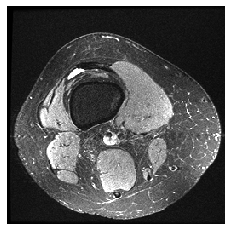

In [10]:
plt.axis("off")
plt.imshow(image, cmap='gray')
image_name = '../../augmentation/image.png'
plt.savefig(image_name)
plt.show()

In [11]:
# use imageio library to read the image (alternatively you can use OpenCV cv2.imread() function)
image = imageio.imread(image_name)

In [12]:
image.shape

(288, 432, 4)

In [13]:
# initialize the augmenter
rotate = iaa.Affine(rotate=(-25, 25)) # rotate image

# augment image
image_rotated = rotate.augment_images([image])[0]

In [14]:
def viz(image):
    plt.axis("off")
    plt.imshow(image, cmap='gray')
    plt.show()

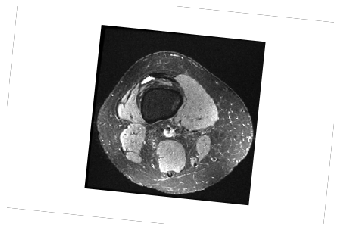

In [15]:
viz(image_rotated)

In [16]:
image = array[0]

In [17]:
image.shape

(256, 256)

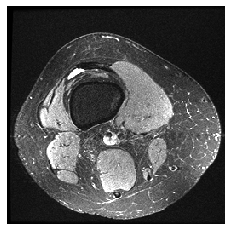

In [18]:
viz(image)

In [19]:
# augment image
image_rotated = rotate.augment_images([image])[0]

In [20]:
image_rotated.shape

(256, 256)

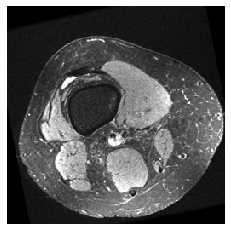

In [21]:
viz(image_rotated)

## 2. Data Augmentation Pipeline

In [22]:
# Define an augmentation pipeline
aug_pipeline = iaa.Sequential([
    iaa.Sometimes(0.5, iaa.GaussianBlur((0, 3.0))), # apply Gaussian blur with a sigma between 0 and 3 to 50% of the images
    # apply one of the augmentations: Dropout or CoarseDropout
    iaa.OneOf([
        iaa.Dropout((0.01, 0.1), per_channel=0.5), # randomly remove up to 10% of the pixels
        iaa.CoarseDropout((0.03, 0.15), size_percent=(0.02, 0.05), per_channel=0.2),
    ]),
    # apply from 0 to 3 of the augmentations from the list
    iaa.SomeOf((0, 3),[
        iaa.Sharpen(alpha=(0, 1.0), lightness=(0.75, 1.5)), # sharpen images
        iaa.Emboss(alpha=(0, 1.0), strength=(0, 2.0)), # emboss images
        iaa.Fliplr(1.0), # horizontally flip
        iaa.Sometimes(0.5, iaa.CropAndPad(percent=(-0.25, 0.25))), # crop and pad 50% of the images
        iaa.Sometimes(0.5, iaa.Affine(rotate=5)) # rotate 50% of the images
    ])
],
random_order=True # apply the augmentations in random order
)

In [23]:
image

array([[ 0,  0,  0, ...,  5,  4,  3],
       [ 0,  0,  0, ...,  8,  6,  8],
       [ 0,  0,  0, ..., 14, 11, 11],
       ...,
       [ 0,  0,  0, ..., 16, 15, 12],
       [ 0,  0,  0, ..., 12, 13, 12],
       [ 0,  0,  0, ..., 11,  7,  9]], dtype=uint8)

In [24]:
# Apply augmentation pipeline to one image
images_aug = np.array([aug_pipeline.augment_image(image) for _ in range(16)])

In [25]:
len(images_aug)

16

In [26]:
images_aug.shape

(16, 256, 256)

In [27]:
def plot_images(images_array, image_name, figsize=(12, 15)):
    
    print('Shape of the array: {}'.format(images_array.shape))
    num_images, _, _ = images_array.shape
    print('Number of images: {}'.format(num_images))

    cols = 5
    rows = num_images // cols
    if num_images % cols > 0: rows += 1

    fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=figsize, dpi=100)
    axes_flattened = axes.flatten()

    for i in range(rows * cols):
        if i < num_images:
            image = images_array[i]
            axes_flattened[i].imshow(image, cmap='gray')
            axes_flattened[i].set_title('Image {}'.format(i))
        axes_flattened[i].axis('off')

    fig.tight_layout()
    
    plt.savefig('../../figures/{}'.format(image_name), bbox_inches='tight')
    
    plt.show()

Shape of the array: (16, 256, 256)
Number of images: 16


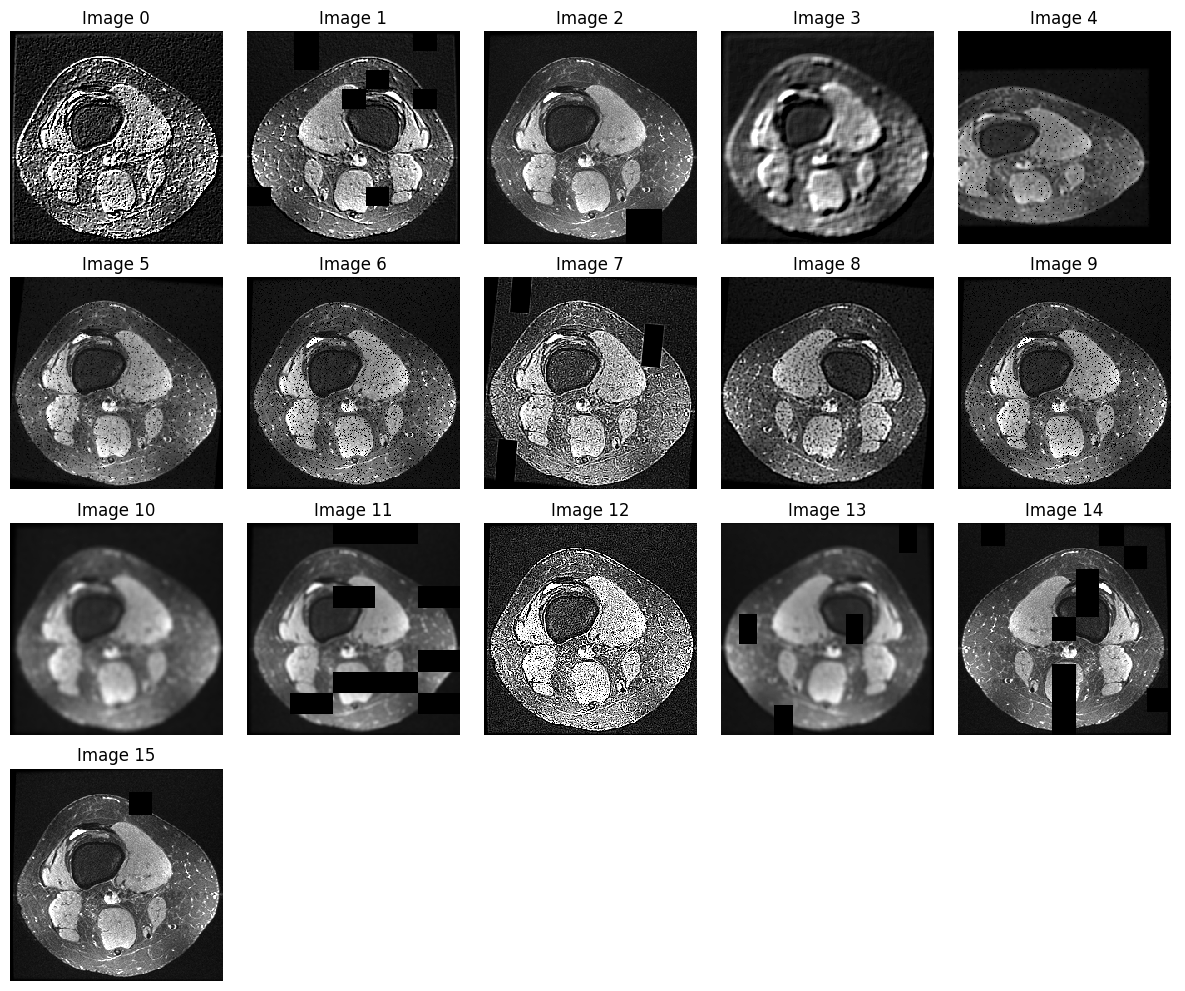

In [28]:
plot_images(images_aug, 'augmentation_II_imgaug_transformations.png', figsize=(12, 10))

## 3. Integrations with Pytorch

In [29]:
import torch
import torch.nn as nn
from torchvision import models


class MRNet(nn.Module):
    
    def __init__(self):
        super().__init__()
        self.pretrained_model = models.alexnet(pretrained=True)
        self.pooling_layer = nn.AdaptiveAvgPool2d(1)
        self.classifer = nn.Linear(256, 1)

    def forward(self, x):
        x = torch.squeeze(x, dim=0)
        features = self.pretrained_model.features(x)
        pooled_features = self.pooling_layer(features)
        pooled_features = pooled_features.view(pooled_features.size(0), -1)
        flattened_features = torch.max(pooled_features, 0, keepdim=True)[0]
        output = self.classifer(flattened_features)
        return output

In [30]:
# Why 3 channels?
# All pre-trained models expect input images normalized in the same way, 
# i.e. mini-batches of 3-channel RGB images of shape (3 x H x W), where H and W are expected to be at least 224.
# https://pytorch.org/docs/stable/torchvision/models.html
CHANNELS = 3

# Import PyTorch
import torchvision.transforms.functional as TF

class MRDataset(Dataset):

    def __init__(self, root_dir, task, plane, train=True, transform=None, weights=None):
        
        print('[DATALOADER] __init__ task: {}, plane: {}, train: {}'.format(task, plane, train))

        super().__init__()
        self.task = task
        self.plane = plane
        self.root_dir = root_dir
        self.train = train
        if self.train:
            self.folder_path = self.root_dir + 'train/{0}/'.format(plane)
            self.records = pd.read_csv(
                self.root_dir + 'train-{0}.csv'.format(task), header=None, names=['id', 'label'])
        else:
            transform = None
            self.folder_path = self.root_dir + 'valid/{0}/'.format(plane)
            self.records = pd.read_csv(
                self.root_dir + 'valid-{0}.csv'.format(task), header=None, names=['id', 'label'])

        self.records['id'] = self.records['id'].map( lambda i: '0' * (4 - len(str(i))) + str(i) )
        self.paths = [ self.folder_path + filename + '.npy' for filename in self.records['id'].tolist()]
        self.labels = self.records['label'].tolist()

        self.transform = transform
        if weights is None:
            pos = np.sum(self.labels)
            neg = len(self.labels) - pos
            self.weights = [1, neg / pos]
        else:
            self.weights = weights
    
    def __len__(self):

        print('[DATALOADER] __len__')
        
        return len(self.paths)

    def __getitem__(self, index):

        print('[DATALOADER] __getitem__ index: {}'.format(index))

        array = np.load(self.paths[index])
        print('Before transformation: {}'.format(array.shape))
        
        label = self.labels[index]
        label = torch.FloatTensor([label])

        if self.transform:
            # one by one
            # array = np.stack([ self.transform.augment_image(array[i]) for i in range(len(array)) ], axis=0)
            # in bulk
            array = self.transform.augment_images(array)
            array = np.stack((array,) * CHANNELS, axis=1)
        else:
            array = np.stack((array,) * CHANNELS, axis=1)
            array = torch.FloatTensor(array)
            
        print('After transformation: {}'.format(array.shape))

        if label.item() == 1:
            weight = np.array([self.weights[1]])
            weight = torch.FloatTensor(weight)
        else:
            weight = np.array([self.weights[0]])
            weight = torch.FloatTensor(weight)

        return array, label, weight

In [31]:
def train_model(model, train_loader, epoch, num_epochs, optimizer):
    
    print('[TRAIN] Train model')

    _ = model.train()

    if torch.cuda.is_available():
        model.cuda()

    y_preds = []
    y_trues = []
    losses = []

    for i, (image, label, weight) in enumerate(train_loader):
        
        optimizer.zero_grad()

        # Copy to CUDA device
        if torch.cuda.is_available():
            image = image.cuda()
            label = label.cuda()
            weight = weight.cuda()

        # Forward pass
        prediction = model.forward(image.float())
        loss = F.binary_cross_entropy_with_logits(
            prediction[0], label[0], weight=weight[0])

        # Backward and Optimize
        loss.backward()
        optimizer.step()

        # Prediction
        y_pred = torch.sigmoid(prediction).item()
        y_true = int(label.item())

        y_preds.append(y_pred)
        y_trues.append(y_true)

        # Metric
        try:
            auc = metrics.roc_auc_score(y_trues, y_preds)
        except:
            auc = 0.5

        # Loss
        loss_value = loss.item()
        losses.append(loss_value)
        
        print('{}. Train Loss: {:.4f},  Train AUC: {:.4f}, Label: {}, Weight: {:.4f}, Prediction: {:.4f}'.format(
            i + 1, loss_value, auc, y_true, weight.item(), y_pred))

        # Show just the first 4 patients
        if i == 4:
            return

In [32]:
mrnet = MRNet()
mrnet = mrnet.cuda()

In [33]:
epoch = 0
iteration_change_loss = 0
patience = 5
log_every = 20
num_epochs = 10

In [34]:
# Adam optimizer as well as a learning rate scheduler
optimizer = optim.Adam(mrnet.parameters(), lr=1e-5, weight_decay=0.1)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, patience=3, factor=.3, threshold=1e-4, verbose=True)

In [35]:
# Define the augmentations
AUG_TRAIN = aug_pipeline # use our pipeline as train augmentations

In [36]:
# AUGMENTATION
train_dataset = MRDataset('../../data/', task, plane, transform=AUG_TRAIN, train=True)

[DATALOADER] __init__ task: acl, plane: axial, train: True


In [37]:
train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=1, shuffle=True, drop_last=False)

[DATALOADER] __len__
[DATALOADER] __len__


In [38]:
# Load one image
for batch_idx, data in enumerate(train_loader):

    array, label, weight = data

    print('## Batch ID: {}, label: {}, weight: {}'.format(batch_idx, label.item(), weight.item()))
    print('Shape of the array: {}'.format(array.shape))

    break

[DATALOADER] __len__
[DATALOADER] __getitem__ index: 176
Before transformation: (36, 256, 256)
After transformation: (36, 3, 256, 256)
## Batch ID: 0, label: 1.0, weight: 4.432692527770996
Shape of the array: torch.Size([1, 36, 3, 256, 256])


In [39]:
def plot_slices(images_array, image_name, figsize=(12, 15)):
    
    print(images_array.shape)
    _, num_slices, _, _, _ = images_array.shape
    print('Number of slices: {}'.format(num_slices))

    cols = 5
    rows = num_slices // cols
    if num_slices % cols > 0: rows += 1

    fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=figsize, dpi=100)
    axes_flattened = axes.flatten()

    for i in range(rows * cols):
        if i < num_slices:
            slice_array = images_array[0][i][0]
            axes_flattened[i].imshow(slice_array, cmap='gray')
            axes_flattened[i].set_title('Slice {}'.format(i))
        axes_flattened[i].axis('off')

    fig.tight_layout()
    
    plt.savefig('../../figures/{}'.format(image_name), bbox_inches='tight')
    
    plt.show()

torch.Size([1, 36, 3, 256, 256])
Number of slices: 36


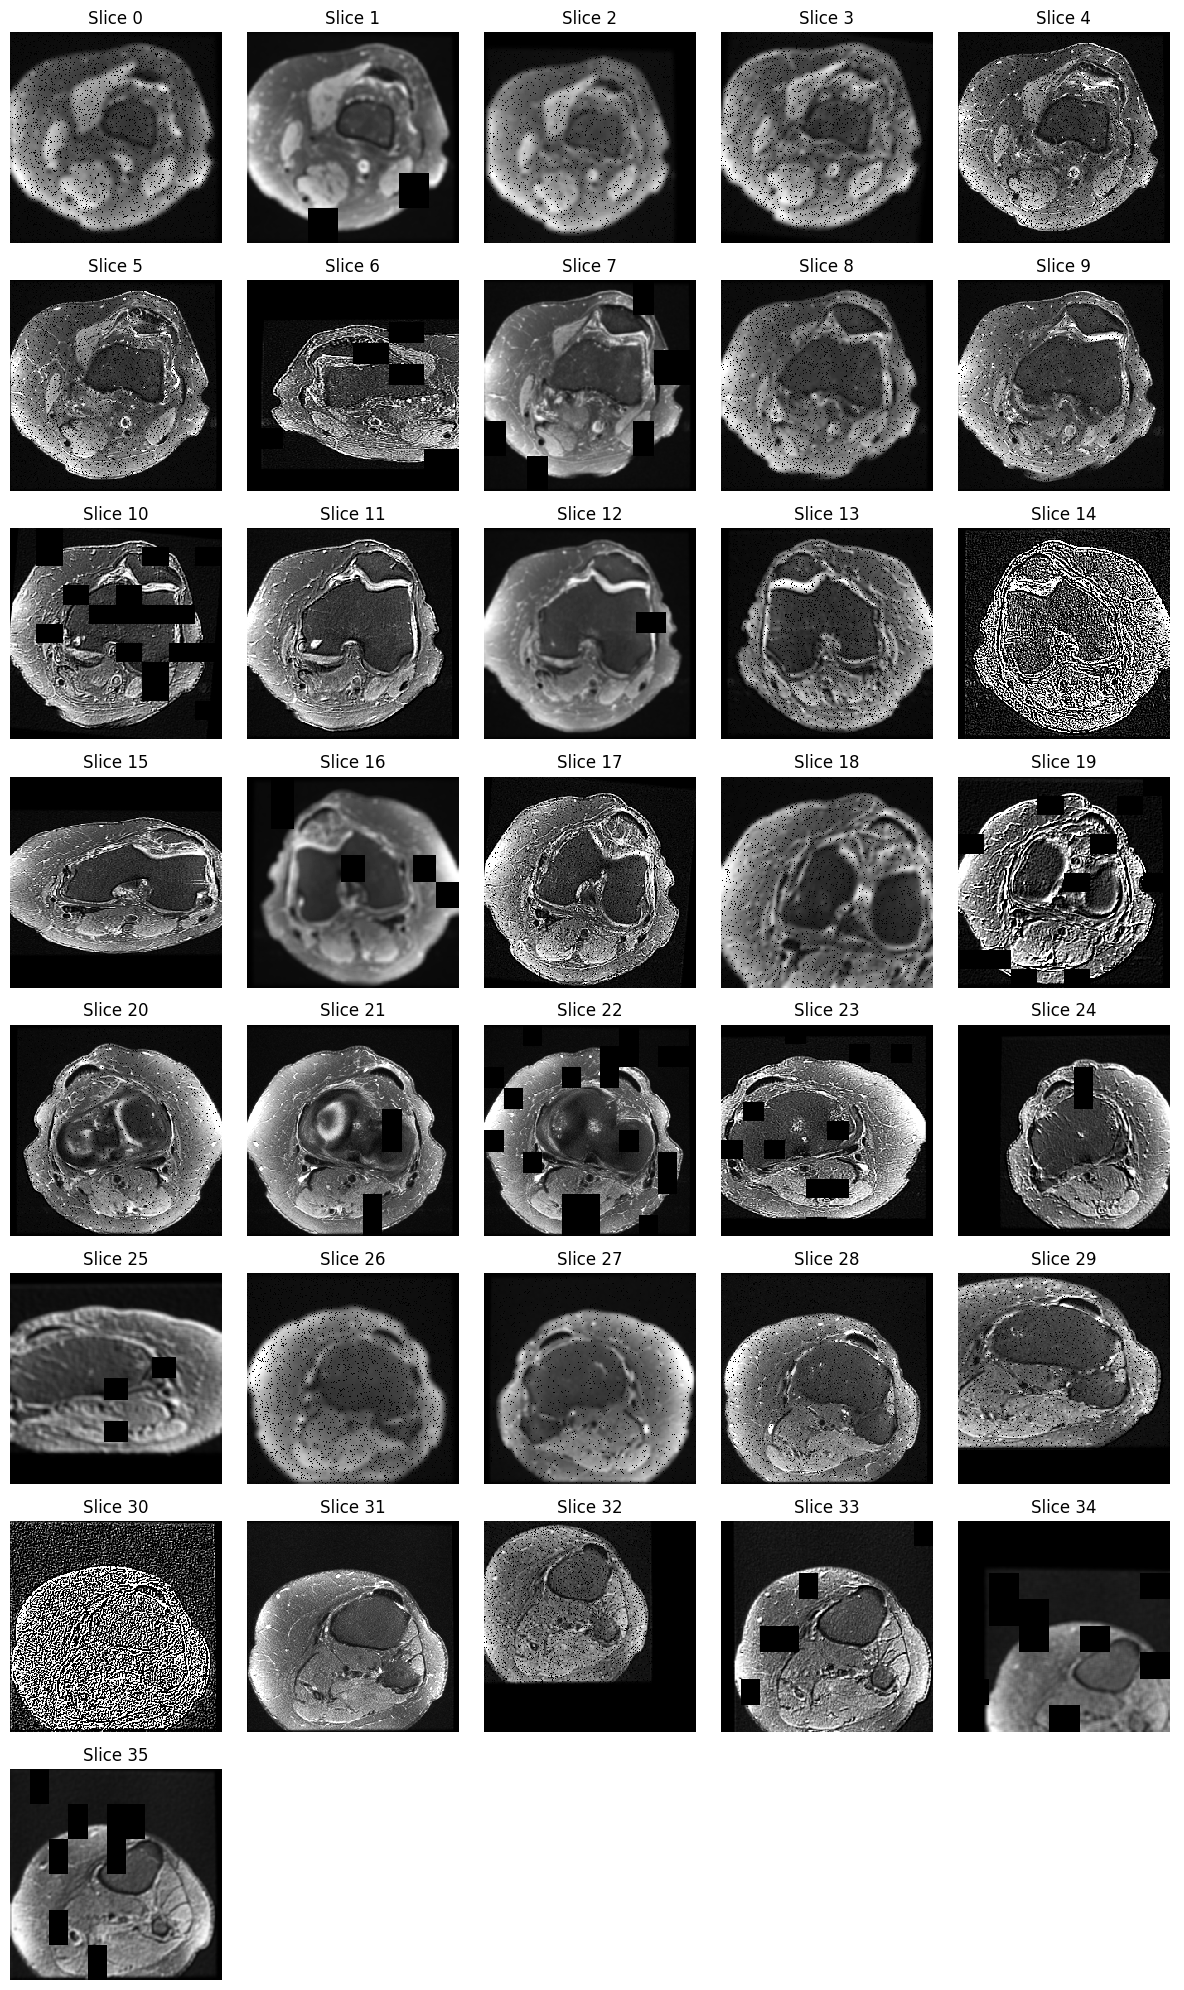

In [40]:
plot_slices(array, 'augmentation_II_imgaug_transformations_II.png', figsize=(12, 20))

In [41]:
train_model(mrnet, train_loader, epoch, num_epochs, optimizer)

[TRAIN] Train model
[DATALOADER] __len__
[DATALOADER] __getitem__ index: 150
Before transformation: (23, 256, 256)
After transformation: (23, 3, 256, 256)
1. Train Loss: 0.1587,  Train AUC: 0.5000, Label: 1, Weight: 4.4327, Prediction: 0.9648
[DATALOADER] __getitem__ index: 818
Before transformation: (24, 256, 256)
After transformation: (24, 3, 256, 256)
2. Train Loss: 19.7460,  Train AUC: 0.5000, Label: 0, Weight: 1.0000, Prediction: 1.0000
[DATALOADER] __getitem__ index: 156
Before transformation: (40, 256, 256)
After transformation: (40, 3, 256, 256)
3. Train Loss: 0.4246,  Train AUC: 0.5000, Label: 0, Weight: 1.0000, Prediction: 0.3460
[DATALOADER] __getitem__ index: 458
Before transformation: (43, 256, 256)
After transformation: (43, 3, 256, 256)
4. Train Loss: 14.5663,  Train AUC: 0.5000, Label: 1, Weight: 4.4327, Prediction: 0.0374
[DATALOADER] __getitem__ index: 477
Before transformation: (29, 256, 256)
After transformation: (29, 3, 256, 256)
5. Train Loss: 31.3665,  Train AUC: